In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("TestSpark").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/13 18:12:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/13 18:12:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
df_v_gpstrips = spark.read.option("header", True).csv("data/v_gpstrips.csv")

# Show the first few rows
df_v_gpstrips.show()

df_v_gpstrips.count()

+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+--------+---------------+--------------------+--------+
| sampno|vehno|gpstripid|gpstravdayid|gpstravdaytripid|         start_time|           end_time|duration_min|distance_miles|avg_speed_mph|max_speed_mph|origin_lon|origin_lat|destination_lon|destination_lat|destination_distfromlast|gaptime|tripareatype|workrelated|nontransport|onsite|looptrip|origin_loc_type|destination_loc_type|    geom|
+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+--------+---------------+--------------

19075

In [4]:
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType

columns_to_convert = ['duration_min', 'distance_miles']  # List of columns to convert

for col_name in columns_to_convert:
    df_v_gpstrips = df_v_gpstrips.withColumn(col_name, col(col_name).cast("float"))

time_columns = ["start_time", "end_time"]

for col_name in time_columns:
    df_v_gpstrips = df_v_gpstrips.withColumn(col_name, col(col_name).cast(TimestampType()))



In [5]:
from pyspark.sql.functions import date_format

df_v_gpstrips = df_v_gpstrips.withColumn("start_time_hour", date_format("start_time", "HH:mm:ss"))

df_v_gpstrips.show()

25/02/13 18:13:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+--------+---------------+--------------------+--------+---------------+
| sampno|vehno|gpstripid|gpstravdayid|gpstravdaytripid|         start_time|           end_time|duration_min|distance_miles|avg_speed_mph|max_speed_mph|origin_lon|origin_lat|destination_lon|destination_lat|destination_distfromlast|gaptime|tripareatype|workrelated|nontransport|onsite|looptrip|origin_loc_type|destination_loc_type|    geom|start_time_hour|
+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+-------

In [6]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas
pandas_df = df_v_gpstrips.select("start_time_hour").toPandas()

# Sort time strings properly before plotting
pandas_df["start_time_hour"] = pd.Categorical(pandas_df["start_time_hour"], ordered=True)



In [7]:
pandas_df

,start_time_hour
0,07:51:23
1,20:58:43
2,08:49:38
3,16:56:04
4,17:44:06
...,...
19070,11:42:09
19071,09:28:54
19072,14:17:43
19073,16:42:33


Text(0, 0.5, 'Frequency')

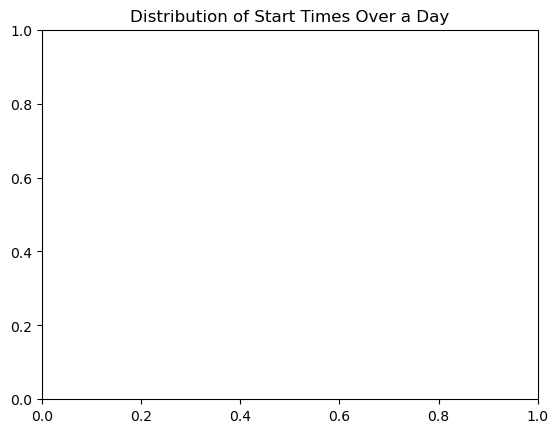

In [9]:

plt.title("Distribution of Start Times Over a Day")
plt.figure(figsize=(12, 6))

pandas_df_sample = pandas_df.sample(frac=0.01, random_state=42)  # Take 10% of data
sns.histplot(pandas_df_sample["start_time_hour"], bins=288, kde=True)

plt.xticks(rotation=45)
plt.xlabel("Time of Day (HH:MM:SS)")
plt.ylabel("Frequency")

In [28]:
for col_name, col_type in df_v_gpstrips.dtypes:
    print(f"Column: {col_name}, Type: {col_type}")


Column: sampno, Type: string
Column: vehno, Type: string
Column: gpstripid, Type: string
Column: gpstravdayid, Type: string
Column: gpstravdaytripid, Type: string
Column: start_time, Type: timestamp
Column: end_time, Type: timestamp
Column: duration_min, Type: float
Column: distance_miles, Type: float
Column: avg_speed_mph, Type: string
Column: max_speed_mph, Type: string
Column: origin_lon, Type: string
Column: origin_lat, Type: string
Column: destination_lon, Type: string
Column: destination_lat, Type: string
Column: destination_distfromlast, Type: string
Column: gaptime, Type: string
Column: tripareatype, Type: string
Column: workrelated, Type: string
Column: nontransport, Type: string
Column: onsite, Type: string
Column: looptrip, Type: string
Column: origin_loc_type, Type: string
Column: destination_loc_type, Type: string
Column: geom, Type: string
Column: start_time_hour, Type: string


In [20]:
from pyspark.sql.functions import mean

mean_value = df_v_gpstrips.select(mean('distance_miles')).collect()[0][0]
print(mean_value)

6.2489625371243624


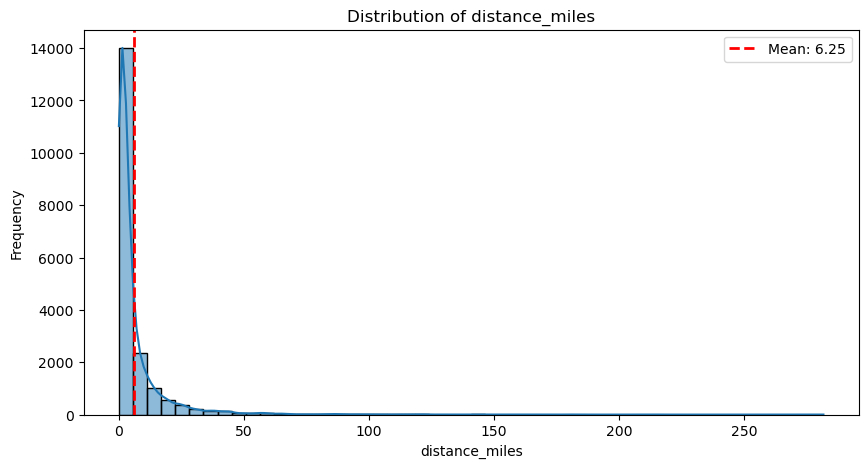

In [21]:


# Convert column to Pandas DataFrame
pandas_df = df_v_gpstrips.select('distance_miles').toPandas()

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(pandas_df['distance_miles'], bins=50, kde=True)
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.xlabel('distance_miles')
plt.ylabel("Frequency")
plt.title(f"Distribution of {'distance_miles'}")
plt.legend()
plt.show()


In [5]:
df_w_gpstrips = spark.read.option("header", True).csv("data/w_gpstrips.csv")

# Show the first few rows
df_w_gpstrips.show()

df_w_gpstrips.count()

+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+-----------+--------+------------+------------+------------+----------+----------+---------------+---------------+----------------+-------+------------+-----------+------------+------+--------+---------------+--------------------+--------+
| sampno|perno|gpstripid|gpstravdayid|gpstravdaytripid|         start_time|           end_time|duration_min|distance_miles|avg_speed_mph|max_speed_mph|travel_mode|nbstages|travmodelist|numuniqmodes|uniqmodelist|origin_lon|origin_lat|destination_lon|destination_lat|distfromlastdest|gaptime|tripareatype|workrelated|no_transport|onsite|looptrip|origin_loc_type|destination_loc_type|    geom|
+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+-----------+--------+------------+------------+------------+-------

121599

In [7]:
df_obd_gpstrips = spark.read.option("header", True).csv("data/obd_gpstrips.csv")

# Show the first few rows
df_obd_gpstrips.show()

df_obd_gpstrips.count()

+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+--------+---------------+--------------------+--------+
| sampno|vehno|gpstripid|gpstravdayid|gpstravdaytripid|         start_time|           end_time|duration_min|distance_miles|avg_speed_mph|max_speed_mph|origin_lon|origin_lat|destination_lon|destination_lat|destination_distfromlast|gaptime|tripareatype|workrelated|nontransport|onsite|looptrip|origin_loc_type|destination_loc_type|    geom|
+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+--------+---------------+--------------

63959

In [8]:
df_obdr_gpstrips = spark.read.option("header", True).csv("data/obdr_trips.csv")

# Show the first few rows
df_obdr_gpstrips.show()

df_obdr_gpstrips.count()

+------+---------+---------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+---------------+--------+---------+---------+--------------+-----------------+---------------------+------------------------+----------+----------+----------+----------+----------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------------+---------------+---------------+------------------+---------------------+-------------------------+----------------------------+----------------------+----------+--------------+
|tripid|obdfileid|triporder|          starttime|            endtime|       starttimeutc|         endtimeutc|tripdurationminutes|     vin|vehicleprotocol|maxspeed| avgspeed| distance|hardbrakecount|extremebrakecount|hardaccelerationcount|extremeaccelerationcount|parameter1|parameter2|parameter3|para

123132